Метод K-means Датасет: Iris. 

In [296]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator
import math
from scipy.stats import multivariate_normal 

df_full = pd.read_csv("Iris.csv")
x = df_full.iloc[:, [1, 2, 3, 4]].values
df_full.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Реализуем «метод локтя» в наборе данных Iris.

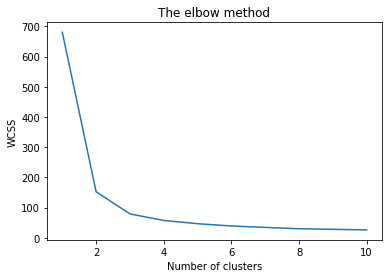

In [297]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

По графику видно, что мы можем взять количество кластеров 3, это будет оптимально

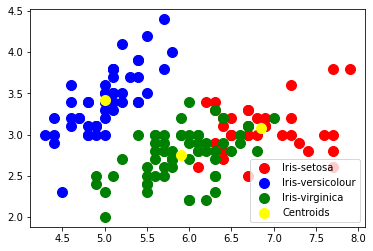

In [298]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')

plt.legend()

Метод Fuzzy C-means

In [299]:
df_full = df_full.drop(['Id'], axis=1)
df_full.shape

(150, 5)

In [300]:
columns = list(df_full.columns)
features = columns[:len(columns)-1]
class_labels = list(df_full[columns[-1]])
df = df_full[features]

Создано только 3 кластера, потому что у нас есть 3 класса в данных Iris.

Диаграммы разброса

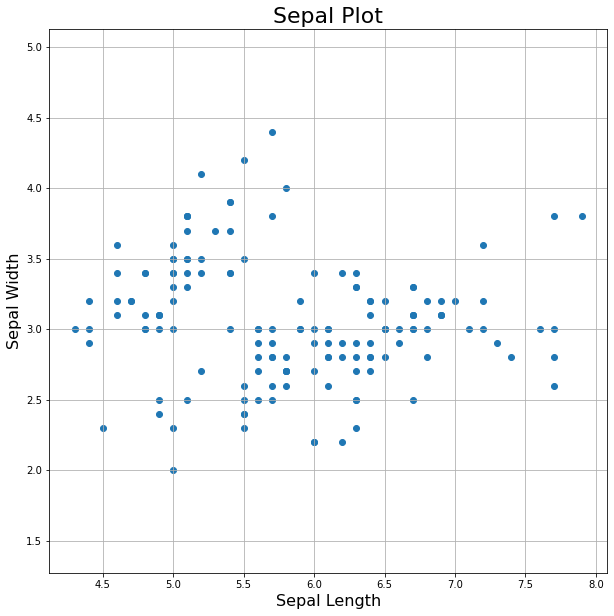

In [301]:
k = 3
MAX_ITER = 100
n = len(df)
m = 1.7 
plt.figure(figsize=(10,10))                                           
plt.scatter(list(df.iloc[:,0]), list(df.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

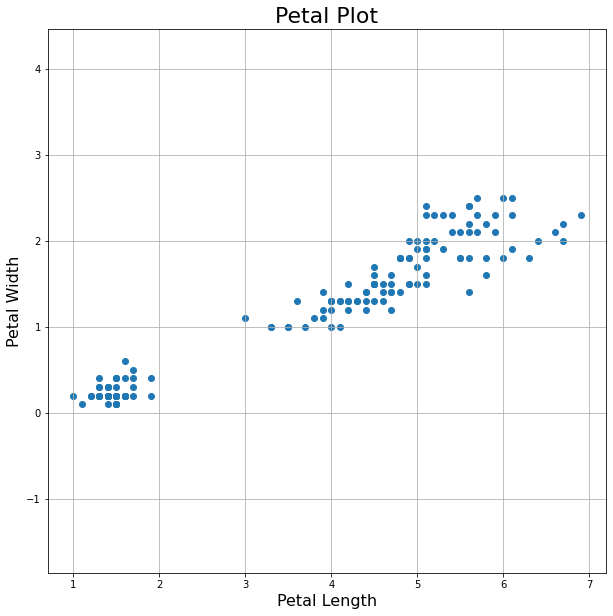

In [302]:
plt.figure(figsize=(10,10))                                           
plt.scatter(list(df.iloc[:,2]), list(df.iloc[:,3]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Petal Length', fontsize=16)                                                 
plt.ylabel('Petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

Расчет точности

In [303]:
def accuracy(cluster_labels, class_labels):
    correct_pred = 0
    #print(cluster_labels)
    seto = max(set(labels[0:50]), key=labels[0:50].count)
    vers = max(set(labels[50:100]), key=labels[50:100].count)
    virg = max(set(labels[100:]), key=labels[100:].count)
    
    for i in range(len(df)):
        if cluster_labels[i] == seto and class_labels[i] == 'Iris-setosa':
            correct_pred = correct_pred + 1
        if cluster_labels[i] == vers and class_labels[i] == 'Iris-versicolor' and vers!=seto:
            correct_pred = correct_pred + 1
        if cluster_labels[i] == virg and class_labels[i] == 'Iris-virginica' and virg!=seto and virg!=vers:
            correct_pred = correct_pred + 1
            
    accuracy = (correct_pred/len(df))*100
    return accuracy

In [304]:
import random
def initializeMembershipMatrix():   
    membership_mat = []
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        
        flag = temp_list.index(max(temp_list))
        for j in range(0,len(temp_list)):
            if(j == flag):
                temp_list[j] = 1
            else:
                temp_list[j] = 0
        
        membership_mat.append(temp_list)
    return membership_mat
membership_mat = initializeMembershipMatrix()

Расчет центра кластера

In [305]:
def calculateClusterCenter(membership_mat):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [p ** m for p in x]
        denominator = sum(xraised)
        temp_num = []
        for i in range(n):
            data_point = list(df.iloc[i])
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, list(zip(*temp_num)))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [306]:
calculateClusterCenter(membership_mat)

[[5.954901960784311,
  3.0705882352941174,
  3.980392156862745,
  1.2960784313725486],
 [5.7434782608695665,
  3.0478260869565217,
  3.554347826086956,
  1.0695652173913042],
 [5.82264150943396, 3.043396226415095, 3.7226415094339607, 1.2169811320754718]]

In [307]:
def updateMembershipValue(membership_mat, cluster_centers): 
    p = float(2/(m-1))
    for i in range(n):
        x = list(df.iloc[i])
        distances = [np.linalg.norm(np.array(list(map(operator.sub, x, cluster_centers[j])))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat

In [308]:
def getClusters(membership_mat):
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

Ниже приведены три различных инициализации. Когда инициализация находится в начале координат, все точки сходятся в один кластер, а для двух других случаев мы получаем кластеры, как мы инициализировали ранее.

Центр кластера в начале координат

In [309]:
def fuzzyCMeansClustering(): 
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    cent_temp = [[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]
    while curr < MAX_ITER:
        if(curr == 0):
            cluster_centers = cent_temp
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

Центр кластеров в случайных местах в пределах многомерного гауссовского распределения с нулевым средним и единичной дисперсией.

In [310]:
def fuzzyCMeansClustering():
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    
    lis1,cent_temp=[],[]
    
    for i in range(0,k):
        Z = list(np.random.multivariate_normal(mean, cov))
        Z1 = list(np.random.multivariate_normal(mean, cov))
        lis1 = Z+Z1
        cent_temp.append(lis1)
    
    
    while curr < MAX_ITER:
        if(curr == 0):
            cluster_centers = cent_temp
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

Центр кластеров в случайных векторах, выбранных из данных.

In [311]:
def fuzzyCMeansClustering(): 
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    while curr < MAX_ITER:
        cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        
        acc.append(cluster_labels)
        
        if(curr == 0):
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        curr += 1
    print("---------------------------")
    print("Partition matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

Расчет точности

In [312]:
labels, centers, acc = fuzzyCMeansClustering()
a = accuracy(labels, class_labels)
acc_lis = [] 
for i in range(0,len(acc)):
    val = accuracy(acc[i], class_labels)
    acc_lis.append(val)
    

Cluster Centers:
[[5.928      3.068      3.934      1.3       ]
 [5.77391304 3.09347826 3.50869565 1.07826087]
 [5.82407407 3.00740741 3.80925926 1.20740741]]
---------------------------
Partition matrix:
[[5.67819162e-05 9.99770794e-01 1.72424329e-04]
 [8.86481003e-04 9.96289054e-01 2.82446451e-03]
 [7.19013163e-04 9.97101689e-01 2.17929773e-03]
 [1.40779918e-03 9.94099369e-01 4.49283135e-03]
 [1.21557690e-04 9.99514701e-01 3.63741759e-04]
 [4.21005758e-03 9.82814052e-01 1.29758903e-02]
 [7.57109076e-04 9.96935703e-01 2.30718744e-03]
 [2.66508464e-06 9.99988930e-01 8.40484306e-06]
 [4.45892768e-03 9.81705950e-01 1.38351228e-02]
 [5.38252020e-04 9.97732122e-01 1.72962558e-03]
 [1.47299186e-03 9.94108059e-01 4.41894904e-03]
 [1.84218020e-04 9.99223933e-01 5.91849425e-04]
 [1.20017378e-03 9.95029147e-01 3.77067942e-03]
 [5.52748695e-03 9.78743610e-01 1.57289028e-02]
 [1.03172071e-02 9.62915366e-01 2.67674268e-02]
 [1.84083981e-02 9.34117495e-01 4.74741073e-02]
 [3.27260430e-03 9.87557694

In [313]:
acc_lis = np.array(acc_lis) 
print("mean=",np.mean(acc_lis))
print("Std dev=",np.std(acc_lis))

mean= 88.61999999999996
Std dev= 1.759431726438965


In [314]:
print("Accuracy = " + str(round(a, 2)))

Accuracy = 88.67


In [315]:
print("Cluster center vectors:") 
print(np.array(centers))

Cluster center vectors:
[[6.80722429 3.05991213 5.68331178 2.06091097]
 [5.00525867 3.40761295 1.48051039 0.25084584]
 [5.8877322  2.75271885 4.36949728 1.40585918]]


Построение графиков

In [316]:
sepal_df = df_full.iloc[:,0:2]
sepal_df = np.array(sepal_df)

In [317]:
#Первая инициализация
#m1 = [0,0]
#m2 = [0,0]
#m3 = [0,0]
#Вторая инициализация
#m1 = [-0.47534495, -0.16392118]
#m2 = [0.89019389, -1.19440781]
#m3 = [1.29107135, 0.48248487]
#Третья инициализация
m1 = random.choice(sepal_df)
m2 = random.choice(sepal_df)
m3 = random.choice(sepal_df)

cov1 = np.cov(np.transpose(sepal_df))
cov2 = np.cov(np.transpose(sepal_df))
cov3 = np.cov(np.transpose(sepal_df))

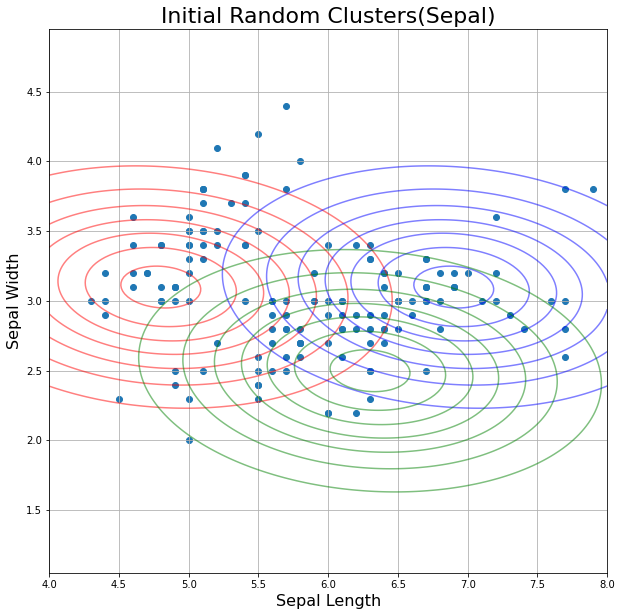

In [318]:
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
#x1 = np.linspace(-1,8,150)  
#x2 = np.linspace(-1,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                  
plt.title('Initial Random Clusters(Sepal)', fontsize=22)                                           
plt.grid()                                                                         
plt.show()

In [319]:
petal_df = df_full.iloc[:,2:4]
petal_df = np.array(petal_df)

In [320]:
#Первая инициализация
#m1 = [0,0]
#m2 = [0,0]
#m3 = [0,0]
#Вторая инициализация
#m1 = [-0.8005044 , -0.7017542]
#m2 = [-2.17962154, -0.96475807]
#m3 = [-0.68988961,  0.54596565]
#Третья инициализация
m1 = random.choice(petal_df)
m2 = random.choice(petal_df)
m3 = random.choice(petal_df)
cov1 = np.cov(np.transpose(petal_df))
cov2 = np.cov(np.transpose(petal_df))
cov3 = np.cov(np.transpose(petal_df))


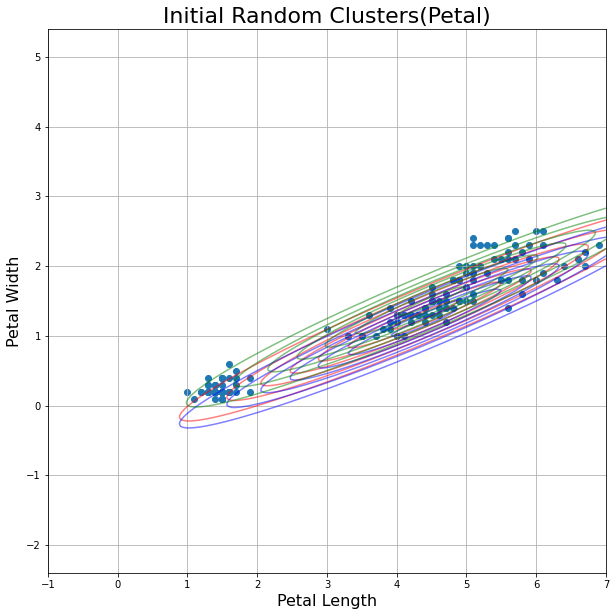

In [321]:
#x1 = np.linspace(0.5,7,150)  
#x2 = np.linspace(-1,4,150)
x1 = np.linspace(-1,7,150)
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))               
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                       
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  
plt.xlabel('Petal Length', fontsize=16)                                                 
plt.ylabel('Petal Width', fontsize=16)                                                  
plt.title('Initial Random Clusters(Petal)', fontsize=22)                                            
plt.grid()                                                                         
plt.show()


In [322]:
seto = max(set(labels[0:50]), key=labels[0:50].count)
vers = max(set(labels[50:100]), key=labels[50:100].count)
virg = max(set(labels[100:]), key=labels[100:].count)

In [323]:
s_mean_clus1 = np.array([centers[seto][0],centers[seto][1]])
s_mean_clus2 = np.array([centers[vers][0],centers[vers][1]])
s_mean_clus3 = np.array([centers[virg][0],centers[virg][1]])

In [324]:
values = np.array(labels) 

searchval_seto = seto
searchval_vers = vers
searchval_virg = virg


ii_seto = np.where(values == searchval_seto)[0]
ii_vers = np.where(values == searchval_vers)[0]
ii_virg = np.where(values == searchval_virg)[0]
ind_seto = list(ii_seto)
ind_vers = list(ii_vers)
ind_virg = list(ii_virg)

In [325]:
sepal_df = df_full.iloc[:,0:2]

In [326]:
seto_df = sepal_df[sepal_df.index.isin(ind_seto)]
vers_df = sepal_df[sepal_df.index.isin(ind_vers)]
virg_df = sepal_df[sepal_df.index.isin(ind_virg)]

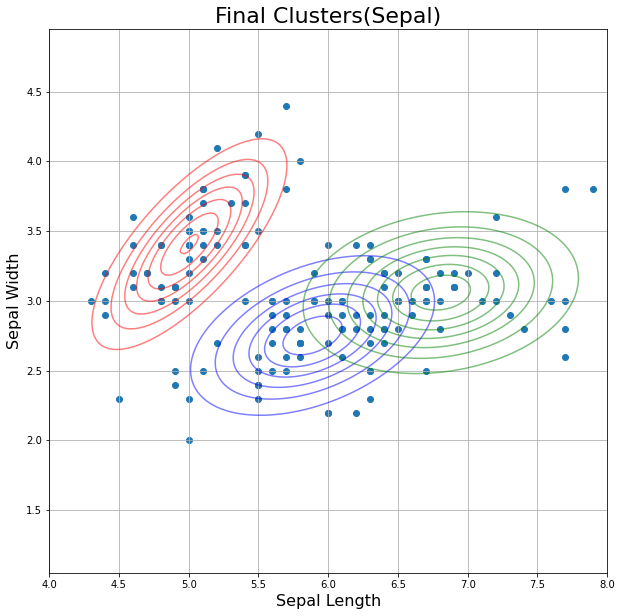

In [327]:
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
sepal_df = np.array(sepal_df)
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(s_mean_clus1, cov_seto)  
Z2 = multivariate_normal(s_mean_clus2, cov_vers)
Z3 = multivariate_normal(s_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                         
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                  
plt.title('Final Clusters(Sepal)', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

In [328]:
p_mean_clus1 = np.array([centers[seto][2],centers[seto][3]])
p_mean_clus2 = np.array([centers[vers][2],centers[vers][3]])
p_mean_clus3 = np.array([centers[virg][2],centers[virg][3]])

In [329]:
petal_df = df_full.iloc[:,2:4]

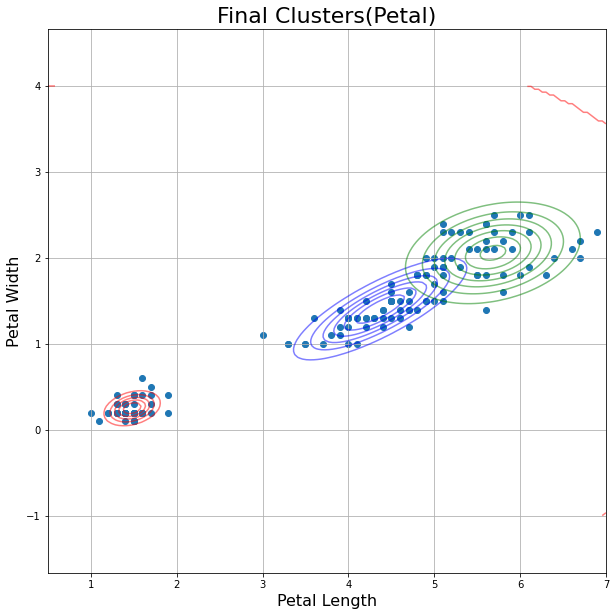

In [330]:
seto_df = petal_df[petal_df.index.isin(ind_seto)]
vers_df = petal_df[petal_df.index.isin(ind_vers)]
virg_df = petal_df[petal_df.index.isin(ind_virg)]
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
petal_df = np.array(petal_df)
x1 = np.linspace(0.5,7,150)  
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(p_mean_clus1, cov_seto)  
Z2 = multivariate_normal(p_mean_clus2, cov_vers)
Z3 = multivariate_normal(p_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))               
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                         
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  
plt.xlabel('Petal Length', fontsize=16)                                                  
plt.ylabel('Petal Width', fontsize=16)                                                  
plt.title('Final Clusters(Petal)', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

Иерархический метод

In [333]:
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from pylab import rcParams
rcParams['figure.figsize'] = 9, 8  # set plot size

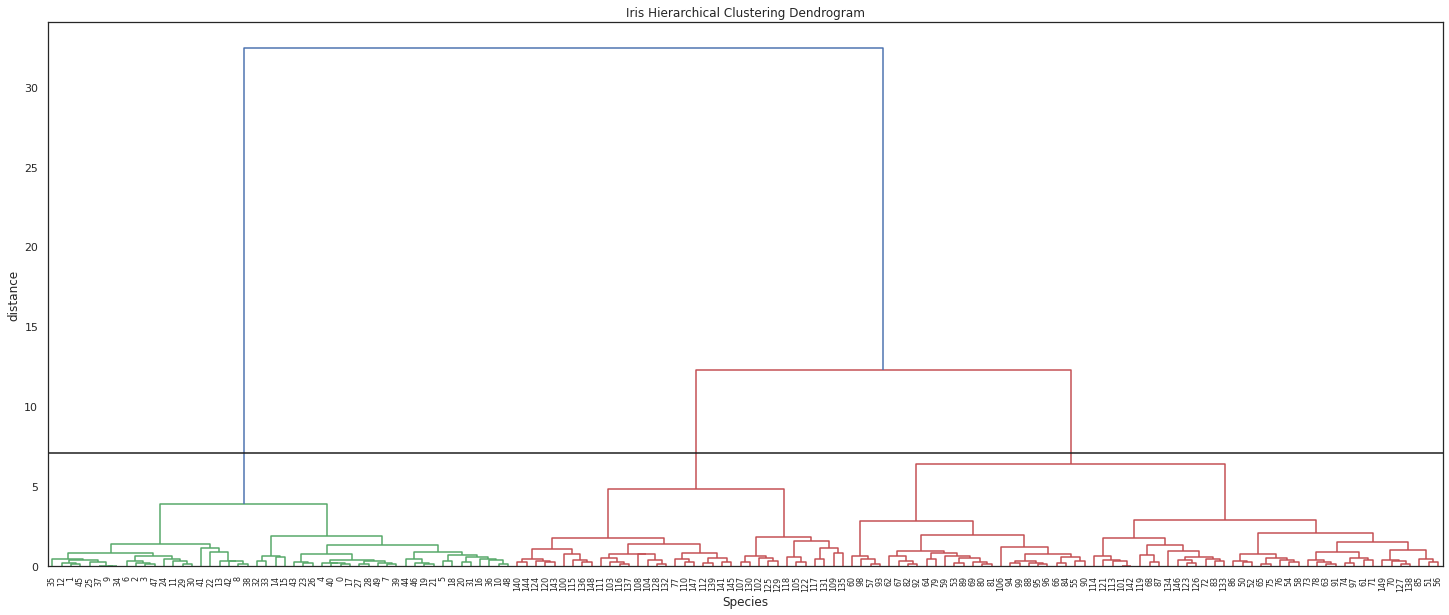

In [335]:
iris = pd.read_csv("Iris.csv") 
iris_SP = iris[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]

from scipy.cluster.hierarchy import dendrogram, linkage


Z = linkage(iris_SP, 'ward')


max_d = 7.08               

plt.figure(figsize=(25, 10))
plt.title('Iris Hierarchical Clustering Dendrogram')
plt.xlabel('Species')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=150,                  
    leaf_rotation=90.,      
    leaf_font_size=8.,      
)
plt.axhline(y=max_d, c='k')
plt.show()

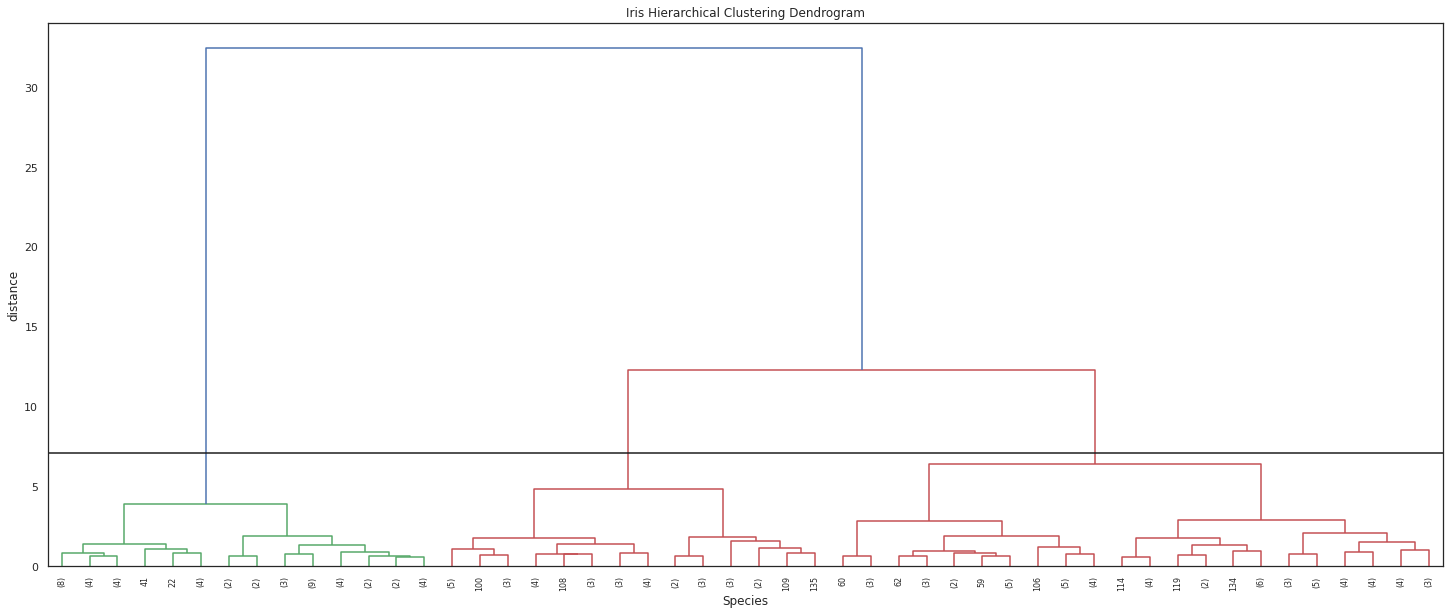

In [336]:
from scipy.cluster.hierarchy import dendrogram, linkage


Z = linkage(iris_SP, 'ward')


max_d = 7.08                

plt.figure(figsize=(25, 10))
plt.title('Iris Hierarchical Clustering Dendrogram')
plt.xlabel('Species')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=50,                  
    leaf_rotation=90.,      
    leaf_font_size=8.,     
)
plt.axhline(y=max_d, c='k')
plt.show()
